In [1]:
pip install pycairo

Note: you may need to restart the kernel to use updated packages.


In [2]:
import foldable_robotics.dxf as frd
import foldable_robotics as fr
import foldable_robotics.manufacturing as frm
from foldable_robotics.layer import Layer
from foldable_robotics.laminate import Laminate
import foldable_robotics.parts.castellated_hinge2 as frc
import shapely.geometry as sg
fr.display_height=300

In [3]:
fr.resolution = 4

In [4]:
desired_degrees = 120
thickness = 1
plain_width = frm.plain_hinge_width(desired_degrees,thickness)
plain_width

1.7320508075688774

In [5]:
support_width = 2 # must be larger than hinge width
kerf = .05
is_adhesive = [False,True,False,True,False]
arc_approx = 10
NUM_LAYERS = 5
bridge_thickness = 1
bounding_box_padding = 10
jig_spacing = 10
jig_dia = 5
body_vertices = frd.read_lwpolylines('grass_bar.dxf',
layer='body',
arc_approx = arc_approx)
body_vertices

[[[1.56136, 70.7607],
  [173.761, 70.7607],
  [173.761, 51.1607],
  [1.56136, 51.1607]]]

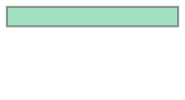

In [6]:
body_polygons = [sg.Polygon(item) for item in body_vertices]
body_polygons[0]

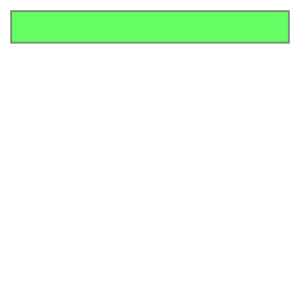

In [7]:
body_layer = Layer(*body_polygons)
body_layer

In [8]:
hole_vertices = frd.read_lwpolylines('grass_bar.dxf',
layer='holes',
arc_approx = arc_approx)
hole_layer = Layer(*[sg.Polygon(item) for item in hole_vertices])
hole_layer

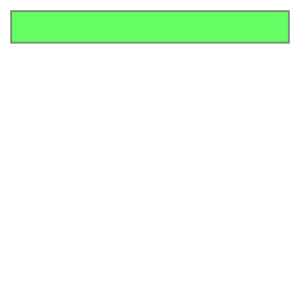

In [9]:
body_layer -= hole_layer
body_layer


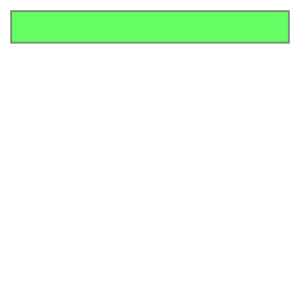

In [10]:
cut_vertices = frd.read_lwpolylines('grass_bar.dxf',
layer='cuts',
arc_approx = arc_approx)
cut_layer = Layer(*[sg.LineString(item) for item in cut_vertices])
cut_layer
cut_layer <<=.5
cut_layer
body_layer -= cut_layer
body_layer

In [11]:
joint_vertices = frd.read_lines('grass_bar.dxf', layer='joints')
joint_vertices

[[[6.561360419843481, 70.76067563916963],
  [6.561360419843481, 51.16067563916963]],
 [[35.76136041984348, 70.76067563916963],
  [35.76136041984348, 51.16067563916964]],
 [[52.76136041984348, 70.76067563916963],
  [52.76136041984348, 51.16067563916963]],
 [[97.76136041984348, 70.76067563916963],
  [97.76136041984348, 51.16067563916963]],
 [[160.7613604198435, 70.76067563916963],
  [160.7613604198435, 51.16067563916963]]]

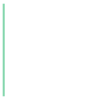

In [12]:
l = sg.LineString(joint_vertices[0])
l

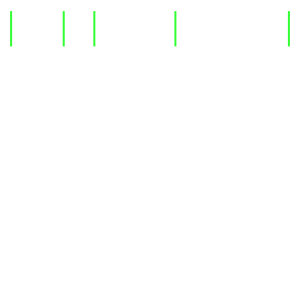

In [13]:
joint_lines_original_layer = Layer(*[sg.LineString(item) for item in joint_vertices])
joint_lines_original_layer

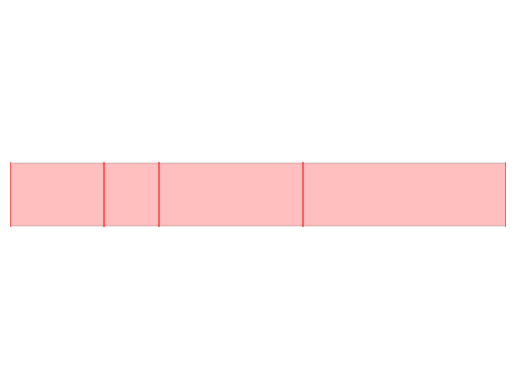

In [14]:
body_layer.plot()
joint_lines_original_layer.plot()

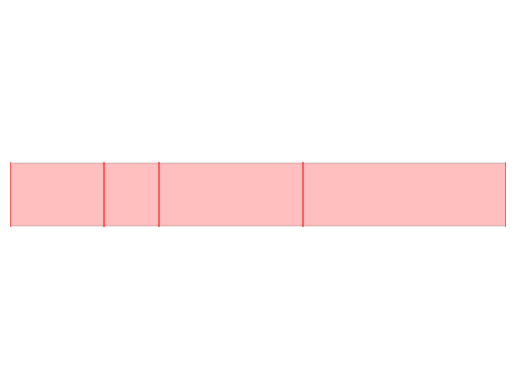

In [15]:
joint_lines_modified_layer = joint_lines_original_layer & body_layer
body_layer.plot()
joint_lines_modified_layer.plot()

In [16]:
modified_joint_vertices = [list(item.coords) for item in joint_lines_modified_layer.geoms]
modified_joint_vertices


[[(6.561360419843481, 70.76067563916963), (6.561360419843481, 51.1607)],
 [(35.76136041984348, 70.76067563916963), (35.76136041984348, 51.1607)],
 [(52.76136041984348, 70.76067563916963), (52.76136041984348, 51.1607)],
 [(97.76136041984348, 70.76067563916963), (97.76136041984348, 51.1607)],
 [(160.7613604198435, 70.76067563916963), (160.7613604198435, 51.1607)]]

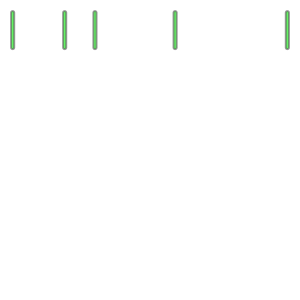

In [17]:
simple_joint_layer = joint_lines_modified_layer << plain_width/2
simple_joint_layer


In [18]:
hole,dummy = frm.calc_hole(modified_joint_vertices,plain_width/2)
fr.my_line_width=0
holes = hole.to_laminate(NUM_LAYERS)
holes<<=.5 # add a little extra material to ensure we removed enough.
holes


<Figure size 640x480 with 0 Axes>

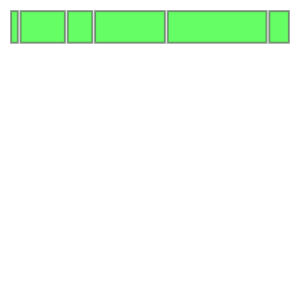

In [19]:
rigid_layer = (body_layer - simple_joint_layer)
rigid_layer

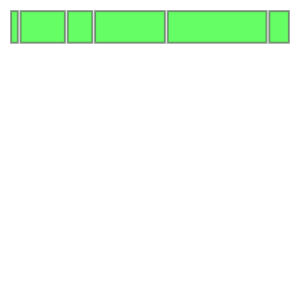

In [20]:
adhesive_layer = rigid_layer & body_layer
adhesive_layer

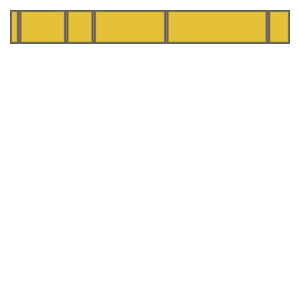

In [21]:
ideal_final_device = Laminate(rigid_layer,adhesive_layer, body_layer,
adhesive_layer,rigid_layer)
ideal_final_device


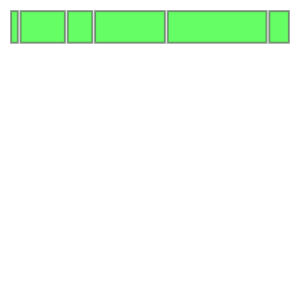

In [22]:
ideal_final_device[0]


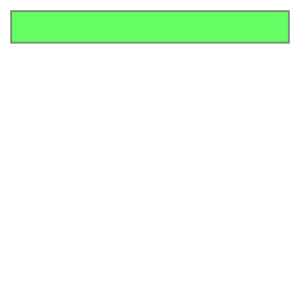

In [23]:
ideal_final_device[2]


In [24]:
bridges = frd.read_lines('grass_bar.dxf', layer='bridge')
bridges
bridges_layer = Layer(*[sg.LineString(item) for item in bridges])
bridges_layer <<= bridge_thickness
bridges_layer

In [25]:
bridges_lam = Laminate(bridges_layer,bridges_layer,Layer(),bridges_layer,bridges_layer)
bridges_lam


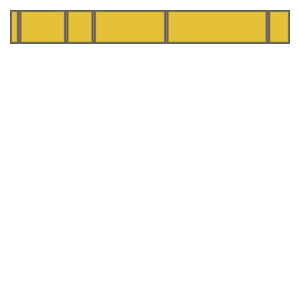

In [26]:
supported_actual_device = ideal_final_device | bridges_lam
supported_actual_device


In [27]:
diff = supported_actual_device - ideal_final_device
removal = frm.cleanup(diff, .1)
removal

In [28]:
removal = frm.keepout_laser(removal)
removal

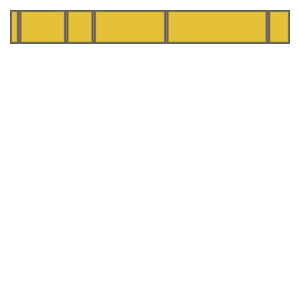

In [29]:
actual_final_device = ideal_final_device- holes - removal
actual_final_device


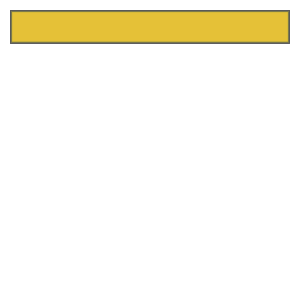

In [30]:
keepout = frm.keepout_laser(actual_final_device)
keepout


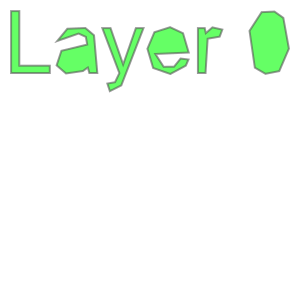

In [31]:
layer_id = frm.build_layer_numbers(NUM_LAYERS,
text_size=jig_dia)
layer_id = layer_id.simplify(.2)
layer_id[0]


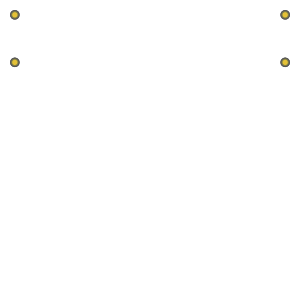

In [32]:
(x1,y1),(x2,y2) = actual_final_device.bounding_box_coords()
w1,h1 = actual_final_device.get_dimensions()
w2 = round(w1/jig_spacing)*jig_spacing+jig_spacing+support_width
h2 = round(h1/jig_spacing)*jig_spacing+jig_spacing+support_width
x1 -= (w2-w1)/2
y1 -= (h2-h1)/2
x2 += (w2-w1)/2
y2 += (h2-h1)/2
points = []
points.append(sg.Point(x1,y1))
points.append(sg.Point(x2,y1))
points.append(sg.Point(x1,y2))
points.append(sg.Point(x2,y2))
alignment_holes_layer = Layer(*points)
alignment_holes_layer<<=(jig_dia/2)
alignment_holes=alignment_holes_layer.to_laminate(NUM_LAYERS)
alignment_holes


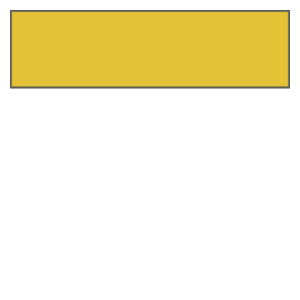

In [33]:
sheet_layer = (alignment_holes_layer<<bounding_box_padding).bounding_box()
sheet=sheet_layer.to_laminate(NUM_LAYERS)
sheet


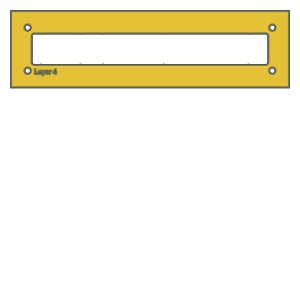

In [34]:
removable_scrap = frm.calculate_removable_scrap(
actual_final_device,sheet,support_width,is_adhesive)
web = removable_scrap-alignment_holes-layer_id.translate(x1+jig_dia,y1-jig_dia/2)
web


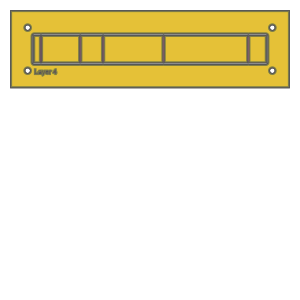

In [35]:
(web|actual_final_device)


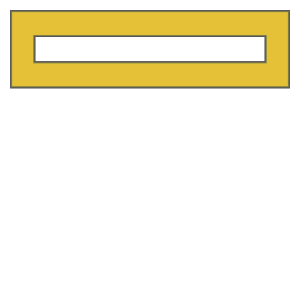

In [36]:
second_pass_scrap = sheet-keepout
second_pass_scrap

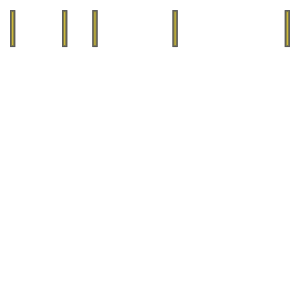

In [37]:
first_pass_scrap = sheet - second_pass_scrap - actual_final_device
first_pass_scrap = frm.cleanup(first_pass_scrap,.00001)
first_pass_scrap


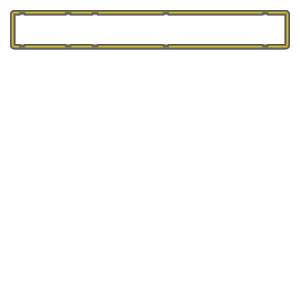

In [38]:
support = frm.support(actual_final_device,
frm.keepout_laser,support_width,support_width/2)
support


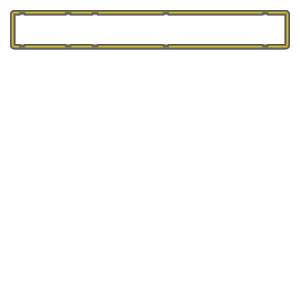

In [39]:
support | bridges_lam


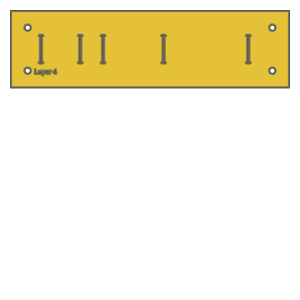

In [40]:
supported_design = web|actual_final_device|support| bridges_lam
supported_design


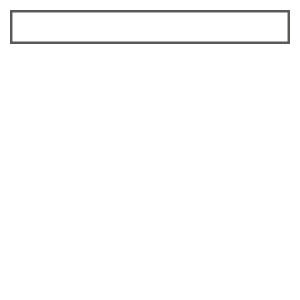

In [41]:
cut_material = (keepout<<kerf)-keepout
cut_material


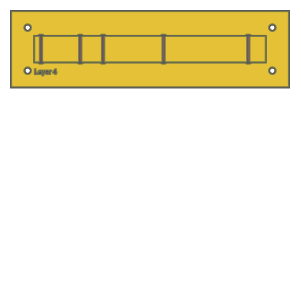

In [42]:
remaining_material = supported_design-cut_material
remaining_material


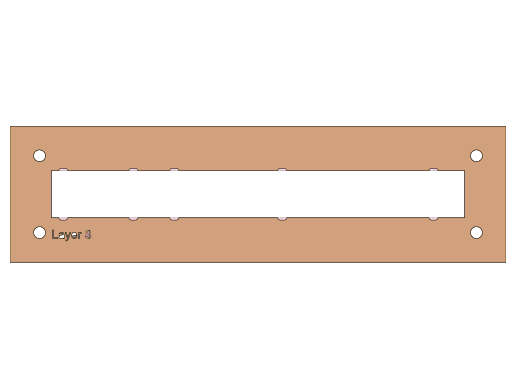

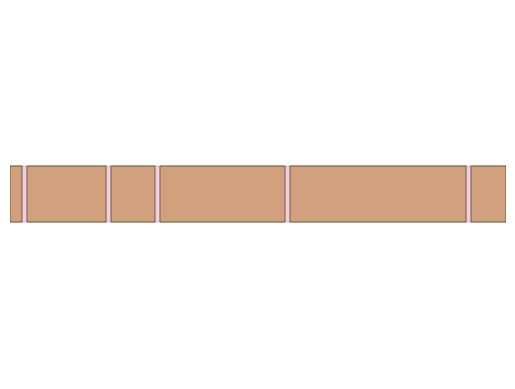

In [43]:
remaining_parts = frm.find_connected(remaining_material,is_adhesive)
for item in remaining_parts:
    item.plot(new=True)


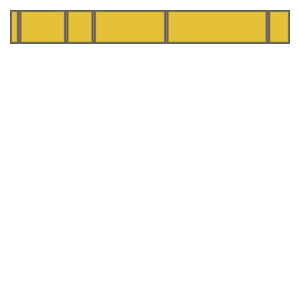

In [44]:
test_part=actual_final_device>>1
for result in remaining_parts:
    if not (result&test_part).is_null():
        break
result

In [45]:
check = (result^actual_final_device)
check>>=1e-1
assert(check.is_null())

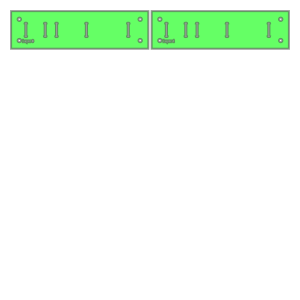

In [46]:
w,h = supported_design.get_dimensions()
p0,p1 = supported_design.bounding_box_coords()
rigid_layer = supported_design[0] | (supported_design[-1].translate(w+5,0))
rigid_layer

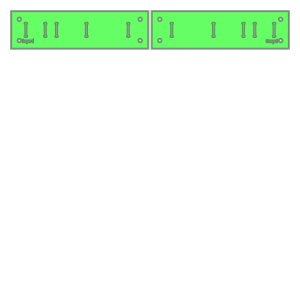

In [47]:
l4 = supported_design[3].scale(-1,1)
p2,p3 = l4.bounding_box_coords()
l4 = l4.translate(p0[0]-p2[0]+w+5,p0[1]-p2[1])
adhesive_layer = supported_design[1] | l4
adhesive_layer


In [48]:
first_pass = Laminate(rigid_layer,adhesive_layer,supported_design[2])
first_pass.export_dxf('first_pass')


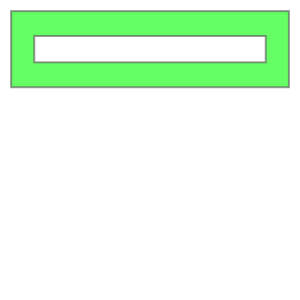

In [49]:
final_cut = sheet - keepout
final_cut = final_cut[0]
final_cut.export_dxf('final_cut')
final_cut


In [50]:
from foldable_robotics.pdf import Page
import foldable_robotics.pdf as frp


In [51]:
# === 2-row grid with mirrored pairs + final_cut in top-right ===
# Configure which laminate layers to use
TOP_IDX = 4        # <- pick the "different" layer number for the NEW TOP row
BOTTOM_IDX = 3     # <- your current layer number for the BOTTOM row

S = frp.ppi / 25.4     # mm -> PDF points
PAD = 30               # page margins (pt)
GAP_X, GAP_Y = 60, 80  # spacing between cells (pt)
CELL_PAD = 12          # inner padding in each cell (pt)

def as_layer(obj):
    # Accept a Layer or Laminate; return a Layer (first layer if Laminate) 
    return obj if hasattr(obj, "get_paths") else obj.layers[0]

def normalize(layer):
    # Scale to points and move bottom-left to (0,0)
    L = layer.scale(S, S)
    (x0, y0), _ = L.bounding_box_coords()
    return L.translate(-x0, -y0)

def mirror_h(layer):
    # Mirror horizontally about the layer's own center
    (a, b) = layer.bounding_box_coords()
    cx = (a[0] + b[0]) / 2
    return layer.translate(-cx, 0).scale(-1, 1).translate(cx, 0)

def size(layer):
    (a, b) = layer.bounding_box_coords()
    return (b[0] - a[0], b[1] - a[1])

def scale_to_fit(layer, w, h, pad=CELL_PAD):
    lw, lh = size(layer)
    if lw == 0 or lh == 0: 
        return layer
    k = min((w - pad)/lw, (h - pad)/lh, 1.0)
    return layer.scale(k, k)

def draw(page, obj):
    # Draw a Layer or Laminate
    layers = getattr(obj, "layers", [obj])
    for lyr in layers:
        for path in lyr.get_paths():
            page.draw_poly(path)

# --- build the six cells (2 rows × 3 cols) ---
# top row: [ left_pair(original @ TOP_IDX), mirrored(TOP_IDX), final_cut ]
# bottom row: [ left_pair(original @ BOTTOM_IDX), mirrored(BOTTOM_IDX), (empty) ]

top_left  = normalize(as_layer(supported_design[TOP_IDX]))
top_right = mirror_h(top_left)

bot_left  = normalize(as_layer(supported_design[BOTTOM_IDX]))
bot_right = mirror_h(bot_left)

final_layer = normalize(as_layer(final_cut))   # final_cut already a Layer in your notebook

# Estimate a reasonable cell size from the largest item
max_w = max(size(L)[0] for L in [top_left, top_right, bot_left, bot_right, final_layer])
max_h = max(size(L)[1] for L in [top_left, top_right, bot_left, bot_right, final_layer])
CELL_W = max_w + 80
CELL_H = max_h + 80

# Page size (2 rows × 3 cols)
page_w = PAD + 3*CELL_W + 2*GAP_X + PAD
page_h = PAD + 2*CELL_H + GAP_Y + PAD

p = Page('grass_plus_final.pdf', height=page_h)

def place(layer, row, col):
    # fit to cell and center within that cell
    Lf = scale_to_fit(layer, CELL_W, CELL_H)
    (a, b) = Lf.bounding_box_coords()
    lw, lh = size(Lf)
    x0 = PAD + col*(CELL_W + GAP_X)
    y0 = page_h - PAD - (row+1)*CELL_H - row*GAP_Y  # rows from top
    dx = x0 + (CELL_W - lw)/2 - a[0]
    dy = y0 + (CELL_H - lh)/2 - a[1]
    draw(p, Lf.translate(dx, dy))

# Top row (row 0)
place(top_left,  0, 0)
place(top_right, 0, 1)
place(final_layer, 0, 2)

# Bottom row (row 1)
place(bot_left,  1, 0)
place(bot_right, 1, 1)
# leave (row 1, col 2) empty, or duplicate final_layer there if you like:
# place(final_layer, 1, 2)

p.close()
print("✅ Exported: grass_two_rows_plus_final.pdf")

✅ Exported: grass_two_rows_plus_final.pdf


In [52]:
# === 2-row grid with mirrored pairs + final_cut in top-right ===
# Configure which laminate layers to use
TOP_IDX = 4        # <- pick the "different" layer number for the NEW TOP row
BOTTOM_IDX = 3     # <- your current layer number for the BOTTOM row

S = frp.ppi / 25.4     # mm -> PDF points
PAD = 30               # page margins (pt)
GAP_X, GAP_Y = 60, 80  # spacing between cells (pt)
CELL_PAD = 12          # inner padding in each cell (pt)

def as_layer(obj):
    # Accept a Layer or Laminate; return a Layer (first layer if Laminate)
    return obj if hasattr(obj, "get_paths") else obj.layers[0]

def normalize(layer):
    # Scale to points and move bottom-left to (0,0)
    L = layer.scale(S, S)
    (x0, y0), _ = L.bounding_box_coords()
    return L.translate(-x0, -y0)

def mirror_h(layer):
    # Mirror horizontally about the layer's own center
    (a, b) = layer.bounding_box_coords()
    cx = (a[0] + b[0]) / 2
    return layer.translate(-cx, 0).scale(-1, 1).translate(cx, 0)

def size(layer):
    (a, b) = layer.bounding_box_coords()
    return (b[0] - a[0], b[1] - a[1])

def scale_to_fit(layer, w, h, pad=CELL_PAD):
    lw, lh = size(layer)
    if lw == 0 or lh == 0:
        return layer
    k = min((w - pad)/lw, (h - pad)/lh, 1.0)
    return layer.scale(k, k)

def draw(page, obj):
    # Draw a Layer or Laminate
    layers = getattr(obj, "layers", [obj])
    for lyr in layers:
        for path in lyr.get_paths():
            page.draw_poly(path)

# --- build the six cells for ONE LEG (2 rows × 3 cols) ---
# top row: [ left_pair(original @ TOP_IDX), mirrored(TOP_IDX), final_cut ]
# bottom row: [ left_pair(original @ BOTTOM_IDX), mirrored(BOTTOM_IDX), (empty) ]

top_left  = normalize(as_layer(supported_design[TOP_IDX]))
top_right = mirror_h(top_left)

bot_left  = normalize(as_layer(supported_design[BOTTOM_IDX]))
bot_right = mirror_h(bot_left)

final_layer = normalize(as_layer(final_cut))   # final_cut already a Layer in your notebook

# Estimate a reasonable cell size from the largest item
max_w = max(size(L)[0] for L in [top_left, top_right, bot_left, bot_right, final_layer])
max_h = max(size(L)[1] for L in [top_left, top_right, bot_left, bot_right, final_layer])
CELL_W = max_w + 80
CELL_H = max_h + 80

# We now want TWO of these 2-row layouts stacked = 4 rows total
NUM_ROWS_PER_LEG = 2
NUM_LEGS = 2
TOTAL_ROWS = NUM_ROWS_PER_LEG * NUM_LEGS  # 4 rows

# Page size (4 rows × 3 cols = two legs on one page)
page_w = PAD + 3*CELL_W + 2*GAP_X + PAD
page_h = PAD + TOTAL_ROWS*CELL_H + (TOTAL_ROWS - 1)*GAP_Y + PAD

p = Page('grass_two_legs_plus_final.pdf', height=page_h)

def place(layer, row, col):
    # fit to cell and center within that cell
    Lf = scale_to_fit(layer, CELL_W, CELL_H)
    (a, b) = Lf.bounding_box_coords()
    lw, lh = size(Lf)
    x0 = PAD + col*(CELL_W + GAP_X)
    # rows counted from top
    y0 = page_h - PAD - (row + 1)*CELL_H - row*GAP_Y
    dx = x0 + (CELL_W - lw)/2 - a[0]
    dy = y0 + (CELL_H - lh)/2 - a[1]
    draw(p, Lf.translate(dx, dy))

# Helper to place one leg’s 2×3 grid starting at a given row index
def place_leg(base_row):
    # Top row for this leg
    place(top_left,   base_row + 0, 0)
    place(top_right,  base_row + 0, 1)
    place(final_layer, base_row + 0, 2)

    # Bottom row for this leg
    place(bot_left,   base_row + 1, 0)
    place(bot_right,  base_row + 1, 1)
    # leave (base_row+1, col 2) empty, or duplicate final_layer if you like:
    # place(final_layer, base_row + 1, 2)

# Leg 1 (rows 0–1)
place_leg(0)

# Leg 2 (rows 2–3), exact same layout duplicated lower on the page
place_leg(2)

p.close()
print("✅ Exported: grass_two_legs_plus_final.pdf")


✅ Exported: grass_two_legs_plus_final.pdf
